# ADS 509 Assignment 5.1: Topic Modeling

Shailja Somani\
ADS 509 Summer 2024\
June 2, 2024

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


In [4]:
!pip install pyLDAvis==3.4.1 --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.7 MB/s eta 0:00:00


In [47]:
# Check Python version
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [48]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [49]:
# add any additional libaries you need here
# Hide warnings for cleanliness before knitting to PDF
import warnings
warnings.filterwarnings('ignore')

# brown.categories was not working properly, so manually downloading Brown corpus
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

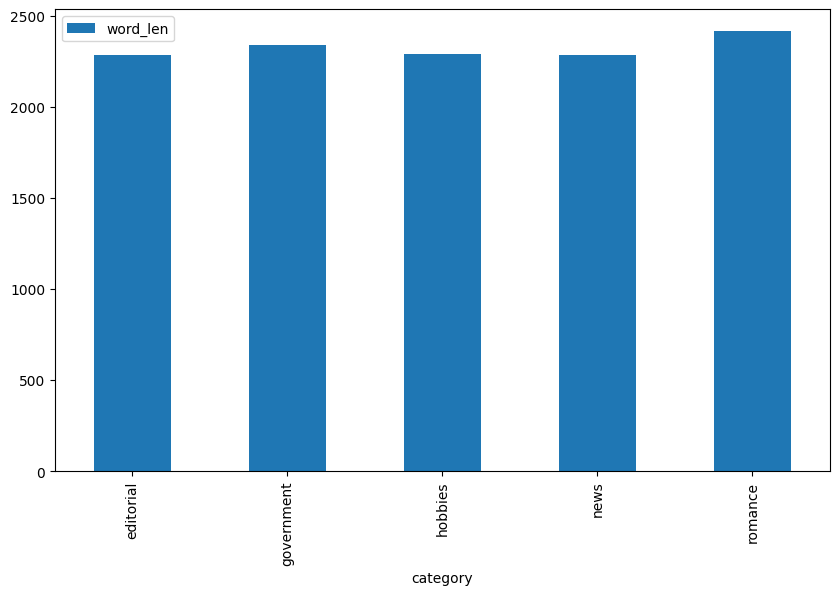

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: The two dataframes `count_text_vectors` and `tfidf_text_vectors` both contain numerical feature representations of the documents in the Brown corpus, but with the features weighted in two different ways. The resulting dataframes/matrices have the exact same shape because both have a row for each document within the corpus and a column for how each word is counted/weighted after each method's data processing.
Prior to word/feature weighting, both methods remove stop words, filter down to words that appear in at least 5 documents, and filter down to words that appear in no more than 70% of the documents (to eliminate very common words that would not help distinguish between documents/categories). Following that, the `count_text_vectors` dataframe simply contains the raw count/frequency of number of times a word appears in each document. On the other hand, the `tfidf_text_vectors` applies TF-IDF so that words with a high frequency in one document and low frequency in others will be weighted higher than a word that has a similar frequency across all documents (as these words would help distinguish different documents better).

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [17]:
# Obtain dominant topic for each document & add to original df
df['nmf_dominant_topic'] = W_text_matrix.argmax(axis=1)
df.head()

,category,id,text,char_len,word_len,NMF_dominant_topic,nmf_dominant_topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0,0


In [22]:
# Create dict to count original categories for each topic
nmf_categories_counter = defaultdict(Counter)

# Loop through all rows in df to get topic & category for each
for idx, row in df.iterrows():
    topic = row['nmf_dominant_topic']
    category = row['category']
    nmf_categories_counter[topic][category] += 1

# Print the count of original categories within each topic from NMF model
for topic, category_counter in nmf_categories_counter.items():
    print("\nTopic " + str(topic) + ":")
    for category, count in category_counter.items():
        print(category + ": " + str(count))


Topic 2:
editorial: 2
government: 26
news: 11
hobbies: 26

Topic 0:
editorial: 20
government: 4
news: 8

Topic 1:
editorial: 4
romance: 29
hobbies: 8

Topic 4:
editorial: 1
news: 8
hobbies: 1

Topic 3:
news: 17
hobbies: 1


Q: How does your five-topic NMF model compare to the original Brown categories?

A: A few of the topic from the NMF model seem to correspond well to a few of the original Brown categories, but none are perfectly clean in that the NMF topic has documents from only one Brown category ***and*** captures all documents from that Brown category.

* Topic 1 from the NMF model matches the original Brown categories fairly well because it captures all the documents within Brown's romance category. However, only approx 71% of the category are documents originally classified as romance, so it does differ significantly from just a romance category.
* Topic 3 does quite well at capturing just news documents as approx 94% of the topic are documents categorized as news documents. However, only approx 39% of the total documents categorized as news originally are within this topic, meaning it fails to capture all news documents.
* Topic 4 also captures mainly news documents with 80% of its documents being originally categorized as news, but fails to capture the variance within the original news category.
* Topic 0 matches the original Brown category of editorial quite well as 62.5% of its documents are from the original editorial category and it captured approx 74% of all editorial documents. However, it does still have a fair amount of noise (per say) from government and news documents.
* Topic 2 is fairly mixed, with a notable amount of documents from the original categories of government, news, and hobbies, alongside a few editorial documents.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [30]:
# Fit LSA model
svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [35]:
# Get dominant topic for each document & add to original df
df['lsa_dominant_topic'] = W_svd_text_matrix.argmax(axis=1)

# Create dict to count original categories for each topic
lsa_categories_counter = defaultdict(Counter)

# Loop through all rows in df to get topic & category for each
for idx, row in df.iterrows():
    topic = row['lsa_dominant_topic']
    category = row['category']
    lsa_categories_counter[topic][category] += 1

# Print the count of original categories within each topic from LSA model
for topic, category_counter in lsa_categories_counter.items():
    print("\nTopic " + str(topic) + ":")
    for category, count in category_counter.items():
        print(category + ": " + str(count))


Topic 0:
editorial: 27
government: 30
news: 34
romance: 21
hobbies: 36

Topic 4:
news: 7

Topic 3:
news: 3

Topic 1:
romance: 8


Q: How does your five-topic LSA model compare to the original Brown categories?

A: The LSA model performs more poorly than the NMF model (which also failed to truly accurately capture the original Brown categories) for a few reasons:

* When given a parameter of identifying 5 topics, the model only classifies documents into 4 dominants topics.
* Topics 3 and 4 both have only news documents, but there are also news documents present in Topic 0. Thus, any one topic fails to capture the variance across news documents.
* Topic 1 aligns with the romance category (as it is only romance documents) but it captures less than 30% of the total romance documents, so it fails to capture the variance across romance documents.
* Topic 0 has the vast majority of the documents and has over 20 documents in each category, thus failing to differentiate in any regard.

In [41]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output?

A: My interpretation is as follows:

* Topic 4 clearly seems like it is about sports, perhaps even baseball specifically, but we can't say that with certainty just by looking at this.
* Topics 0 and 2 seem like they could be about government, speeches, formal events, etc because they contain government terms (president, kennedy, state), formal prefixes (mr, mrs), and words that may reference speeches (said, state).
* Topic 1 does not hold very descriptive/distinctive words at all and Topic 3 seems to just hold a random grabbag of words.
* There are certain words shared by multiple topics (mrs, mr, game, etc), which may contribute to the lack of clear delineations & Brown's original categories being spread across multiple topics.  

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [42]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [43]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model?
['editorial','government','news','romance','hobbies']

A: I draw the following inferences from the displayed topics for the LDA model:

* Topic 0 seems to have multiple terms associated with sports, so it may correlate with the hobbies category from the original Brown categories.
* Topic 1 seems related to government programs and Topic 2 seems related to government/formal agents, so perhaps Topic 1 is correlated with the news category and Topic 2 is with the government category.
* Topic 3 seems related to business, but "feed" seems a bit out of place unless it's regarding farming business or something as such. I'm not sure which of the Brown categories this would correlate to.
* Topic 4's words seem quite random, especially "said" and "good," which are both pretty general words. Given the categories remaining, perhaps this correlates with romance, but I do not feel confident about that guess.

In [44]:
# Get dominant topic for each document & add to original df
df['lda_dominant_topic'] = W_lda_text_matrix.argmax(axis=1)

# Create dict to count original categories for each topic
lda_categories_counter = defaultdict(Counter)

# Loop through all rows in df to get topic & category for each
for idx, row in df.iterrows():
    topic = row['lda_dominant_topic']
    category = row['category']
    lda_categories_counter[topic][category] += 1

# Print the count of original categories within each topic from LDA model
for topic, category_counter in lda_categories_counter.items():
    print("\nTopic " + str(topic) + ":")
    for category, count in category_counter.items():
        print(category + ": " + str(count))


Topic 2:
editorial: 22
government: 2
news: 31
hobbies: 1

Topic 4:
editorial: 1
romance: 29
hobbies: 2

Topic 0:
editorial: 3
news: 9
hobbies: 16

Topic 1:
editorial: 1
government: 20
news: 3
hobbies: 14

Topic 3:
government: 8
news: 1
hobbies: 3



Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: The LDA model's topics compare to the original Brown categories as follows:

* Topic 2 has mainly editorial and news documents (which makes sense given the words such as president, state, etc). It captures most of the editorial documents, but there are a significant amount of news documents in other topics as well.
* Topic 4 has all the romance documents and over 90% of the topic is those romance documents, so this does quite well at aligning with Brown's original romance category.
* Brown's original hobbies category is scattered around all 5 topics, with the highest number of hobbies documents in Topic 0, but that being less than 50% of all hobbies documents in the corpus.
* Topic 1 has a mix of 4 original categories, with government and hobbies being the main two.
* Topic 3 is 2/3 government documents.

In conclusion, Topic 4 does quite a good job at capturing the romance category from Brown's original categories, but all other topics and categories are not very well-aligned.

In [45]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [46]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: My conclusions are as follows:

* Topics 1 and 5 have good differentiation from the other topics, but 2, 3, and 4 are less differentiated. 2 and 3 are closed and have some overlap. 4 is almost completely inside 2.
* Given the above, we see (and it makes sense that) the Top 30 Most Salient Terms has a lot of overlap with the Top 30 Most Relevant Terms for Topics 2-4 as those 3 share a lot of common terms. However, the Top 30 Most Relevant Terms for Topics 1 and 5 are fairly different (except "said" which is the top term for Topic 5 and the Top 30 overall most relevant terms).
* The top 30 terms for Topic 1 seem sports related still (as earlier noted, Topic 0 above = Topic 1 here), with terms like home, game, ball, won, etc.
* The top 30 terms for Topic 5 seem quite random, with many of the words being common English words overall and thus not being too distinctive. The words include come, came, know, thought, man, etc, all of which are quite general words.
* The top 30 terms for Topics 2 - 4 seem related to government, including terms such as "state", "tax", "government" itself, "united" and "states." The lack of clear differentiation between the three topics on the graph is representative of the lack of clear differentiation between the top 30 terms for each topic.

*Note:* The visualization is not displaying on Github properly, so a screenshot of the intertopic distance map and overall term frequency are included in the Github repo.  
